# How to use `if` statements

## Introduction
In this tutorial, you will learn how to use `if` statements in WorkTree.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## First workflow: if
Suppose we want to calculate:
```python
if x > 0:
    z = x - y
else:
    z = x*y
```



### Create node
In order to create a dynamic workflow based on the input value, we need a create a `WorkTree` and then treat this `WorkTree` as a node.

In [31]:
from aiida_worktree import node, WorkTree
from aiida.engine import calcfunction
from aiida.orm import List

# define add node
@node()
@calcfunction
def add(x, y):
    return x + y

# define multiply node
@node()
@calcfunction
def multiply(x, y):
    return x*y

# define assign node to clone the input value to the output
@node()
@calcfunction
def assign(x):
    return x.clone()

# Create a WorkTree which is dynamically generated based on the input
@node.group(outputs = [["assign1", "result", "result"]])
def add_multiply_if(x, y):
    from aiida.orm import load_node
    nt = WorkTree("add_multiply_if")
    nt.nodes.new(assign, name="assign1")
    if x.value > 0:    
        nt.nodes.new(add, name="add1", x=x, y=y)
        nt.links.new(nt.nodes["add1"].outputs[0], nt.nodes["assign1"].inputs[0])
    else:
        nt.nodes.new(multiply, name="multiply1", x=x, y=y)
        nt.links.new(nt.nodes["multiply1"].outputs[0], nt.nodes["assign1"].inputs[0])
    return nt

### Create the workflow


In [32]:
from aiida_worktree import WorkTree
from aiida.orm import Int, List

x = Int(-1)
y = Int(2)
nt = WorkTree("if_node")
add_multiply_if1 = nt.nodes.new(add_multiply_if, name="add_multiply_if1", x=x, y=y)

nt.submit(wait=True)

[INFO] 2023-07-26 16:05:36 nodetree: Create NodeTree: if_node


### Check status and results


In [36]:
print("State of WorkTree:   {}".format(nt.state))
print('Result of add_if1      : {}'.format(nt.nodes["add_multiply_if1"].node.outputs.group_outputs.result.value))

State of WorkTree:   FINISHED
Result of add_if1      : -2


Generate node graph from the AiiDA process,and we can see that the `multiply` node is executed.

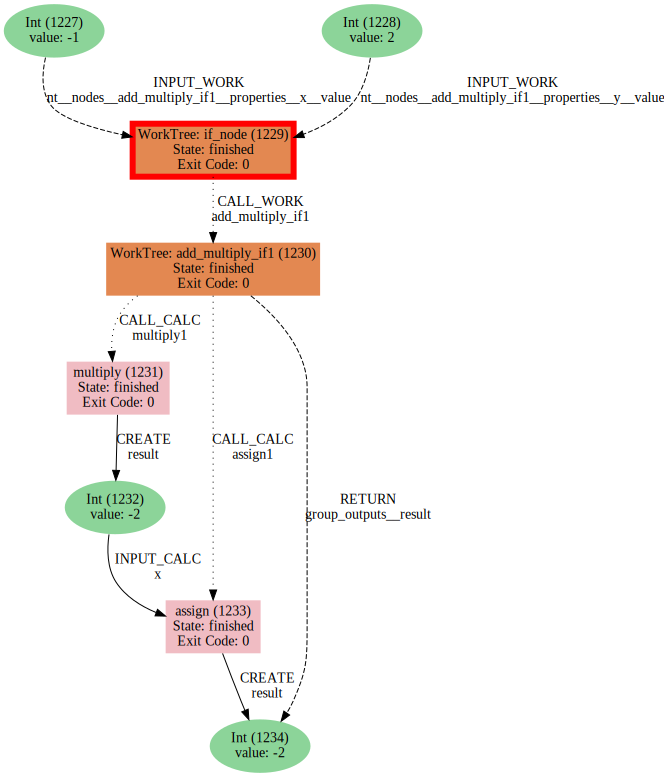

In [37]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(nt.pk)

Run the workflow using a different input value, and this time the `add` function will be called.

[INFO] 2023-07-26 16:16:30 nodetree: Create NodeTree: if_node


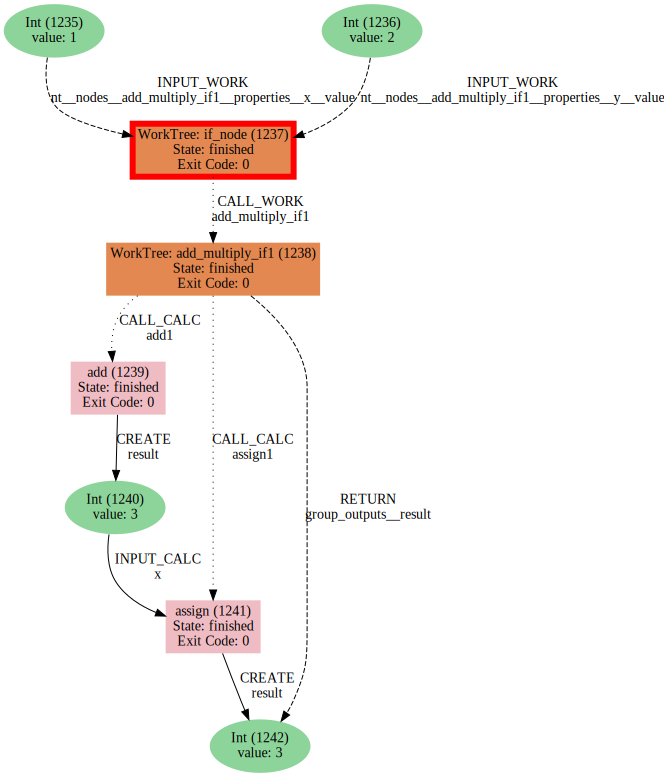

In [38]:
x = Int(1)
y = Int(2)
nt = WorkTree("if_node")
add_multiply_if1 = nt.nodes.new(add_multiply_if, name="add_multiply_if1", x=x, y=y)

nt.submit(wait=True)
generate_node_graph(nt.pk)
